In [1]:
import cv2
import mediapipe as mp
import numpy as np
import time

In [2]:
mp_drawing = mp.solutions.drawing_utils
mp_face_mesh = mp.solutions.face_mesh

Eye Aspect Ratio (EAR)

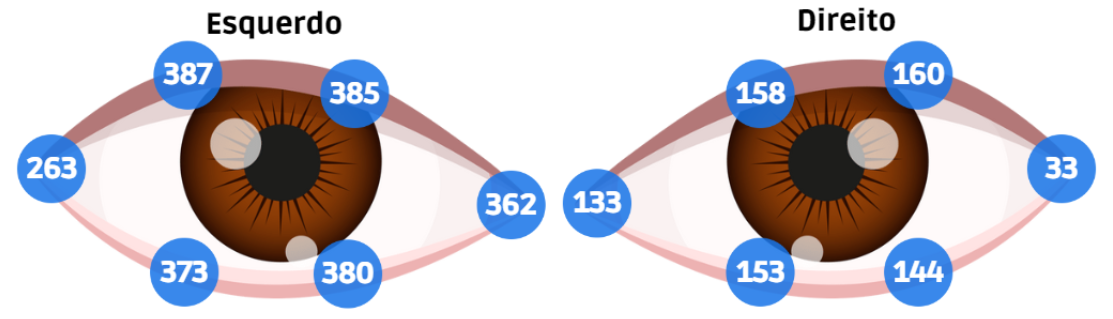

In [3]:
p_olho_esq = [385, 380, 387, 373, 362, 263]
p_olho_dir = [160, 144, 158, 153, 33, 133]

In [4]:
p_olhos = p_olho_esq + p_olho_dir
p_olhos

[385, 380, 387, 373, 362, 263, 160, 144, 158, 153, 33, 133]

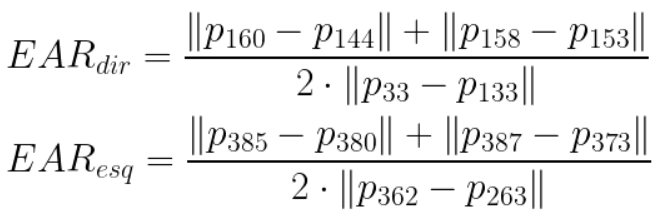

Mouth Aspect Ratio (MAR)

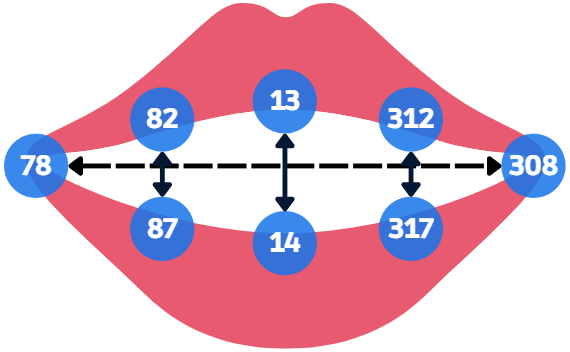

In [5]:
p_boca = [82, 87, 13, 14, 312, 317, 78, 308]

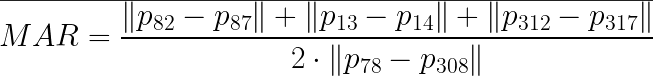

In [6]:
def calculo_ear(face, p_olho_dir, p_olho_esq):
    try:
        face = np.array([[coord.x, coord.y] for coord in face])
        face_esq = face[p_olho_esq,:]
        face_dir = face[p_olho_dir,:]

        ear_esq = np.linalg.norm(face_esq[0] - face_esq[1]) + np.linalg.norm(face_esq[2] - face_esq[3]) / (2 * (np.linalg.norm(face_esq[4] - face_esq[5])))
        ear_dir = np.linalg.norm(face_dir[0] - face_dir[1]) + np.linalg.norm(face_dir[2] - face_dir[3]) / (2 * (np.linalg.norm(face_dir[4] - face_dir[5])))

    except:
        ear_esq = 0.0
        ear_dir = 0.0
        
    media_ear = (ear_esq + ear_dir) / 2
    
    return media_ear

In [7]:
def calculo_mar(face, p_boca):
    try:
        face = np.array([[coord.x, coord.y] for coord in face])
        face_boca = face[p_boca,:]

        mar = (np.linalg.norm(face_boca[0] - face_boca[1]) + np.linalg.norm(face_boca[2] - face_boca[3]) + np.linalg.norm(face_boca[4] - face_boca[5])) / (2 * np.linalg.norm(face_boca[6] - face_boca[7]))

    except:
        mar = 0.0
    
    return mar

In [ ]:
ear_limiar = 0.13
mar_limiar = 0.2
dormindo = 0
contagem_piscadas = 0
c_tempo = 0
contagem_temporaria = 0
contagem_lista = []

t_piscadas = time.time()

cap = cv2.VideoCapture(0)

with mp_face_mesh.FaceMesh(min_detection_confidence=0.5, min_tracking_confidence=0.5) as facemesh:
    while cap.isOpened():
        sucesso, frame = cap.read()
        if not sucesso:
            print('Ignorando o frame vazio da câmera.')
            continue
        comprimento, largura, _ = frame.shape

        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        saida_facemesh = facemesh.process(frame)
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)

        try:
            for face_landmarks in saida_facemesh.multi_face_landmarks:
                mp_drawing.draw_landmarks(frame, face_landmarks, mp_face_mesh.FACEMESH_CONTOURS, landmark_drawing_spec=mp_drawing.DrawingSpec(color=(255,102,102), thickness=1, circle_radius=1), connection_drawing_spec=mp_drawing.DrawingSpec(color=(102,204,0), thickness=1, circle_radius=1))
                face = face_landmarks.landmark
                for id_coord, coord_xyz in enumerate(face):
                    if id_coord in p_olhos:
                        coord_cv = mp_drawing._normalized_to_pixel_coordinates(coord_xyz.x, coord_xyz.y, largura, comprimento)
                        cv2.circle(frame, coord_cv, 2, (255, 0, 0), -1)
                    if id_coord in p_boca:
                        coord_cv = mp_drawing._normalized_to_pixel_coordinates(coord_xyz.x, coord_xyz.y, largura, comprimento)
                        cv2.circle(frame, coord_cv, 2, (255, 0, 0), -1)

                ear = calculo_ear(face, p_olho_dir, p_olho_esq)
                cv2.rectangle(frame, (0, 1), (290, 140), (58, 58, 55), -1)
                cv2.putText(frame, f"EAR: {round(ear, 2)}", (1, 24), cv2.FONT_HERSHEY_DUPLEX, 0.9, (255, 255, 255), 2)

                mar = calculo_mar(face, p_boca)
                cv2.putText(frame, f"MAR: {round(mar, 2)} {'Aberta' if mar >= mar_limiar else 'Fechada'}", (1, 50), cv2.FONT_HERSHEY_DUPLEX, 0.9, (255, 255, 255), 2)

                if ear < ear_limiar and mar < mar_limiar:
                    t_inicial = time.time() if dormindo == 0 else t_inicial
                    contagem_piscadas = contagem_piscadas + 1 if dormindo == 0 else contagem_piscadas
                    dormindo = 1
                if (dormindo == 1 and ear >= ear_limiar) or (ear <= ear_limiar and mar >= mar_limiar):
                    dormindo = 0
                t_final = time.time()
                tempo_decorrido = t_final - t_piscadas

                if tempo_decorrido >= (c_tempo + 1):
                    c_tempo = tempo_decorrido
                    piscadas_ps = contagem_piscadas - contagem_temporaria
                    contagem_temporaria = contagem_piscadas
                    contagem_lista.append(piscadas_ps)
                    contagem_lista = contagem_lista if (len(contagem_lista) <= 60) else contagem_lista[-60:]
                piscadas_pm = 15 if tempo_decorrido <= 60 else sum(contagem_lista)

                cv2.putText(frame, f"Piscadas: {contagem_piscadas}", (1, 120), cv2.FONT_HERSHEY_DUPLEX, 0.9, (109, 233, 219), 2)

                tempo = (t_final - t_inicial) if dormindo == 1 else 0.0
                cv2.putText(frame, f"Tempo: {round(tempo, 3)}", (1, 80), cv2.FONT_HERSHEY_DUPLEX, 0.9, (255, 255, 255), 2)

                if piscadas_pm < 10 or tempo >= 1.5:
                    cv2.rectangle(frame, (30, 400), (610, 452), (109, 233, 219), -1)
                    cv2.putText(frame, f"Pode ser que voce esteja com sono,", (60, 420), cv2.FONT_HERSHEY_DUPLEX, 0.85, (58, 58, 55), 1)
                    cv2.putText(frame, f"considere descansar.", (180, 450), cv2.FONT_HERSHEY_DUPLEX, 0.85, (58, 58, 55), 1)
        except:
            pass

        cv2.imshow('Camera', frame)
        if cv2.waitKey(10) & 0xFF == ord('c'):
            break
cap.release()
cv2.destroyAllWindows()